In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

plt.style.use("bmh")
from IPython.core.debugger import set_trace

In [2]:
df = pd.read_csv("DATA/eventos.csv",parse_dates=["start","duration"])

df.dropna(how="any", axis=0,inplace=True)

In [3]:
df = df[df.RADAR > 0]

In [4]:
df.duration = df.duration.apply(pd.to_timedelta)

In [5]:
df.head()

,start,station,duration,Pluviometro,RADAR,ERROR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364
2,2016-10-14 07:20:00,MB_ANHA1,00:10:00,0.25,0.594438,-0.344438
3,2016-10-14 08:10:00,MB_ANHA1,00:50:00,3.25,1.569860,1.680140
4,2016-10-14 09:10:00,MB_ANHA1,01:40:00,5.00,2.367961,2.632039
6,2016-10-14 11:40:00,MB_ANHA1,00:10:00,0.25,0.274750,-0.024750


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8544 entries, 1 to 21017
Data columns (total 6 columns):
start          8544 non-null datetime64[ns]
station        8544 non-null object
duration       8544 non-null timedelta64[ns]
Pluviometro    8544 non-null float64
RADAR          8544 non-null float64
ERROR          8544 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1), timedelta64[ns](1)
memory usage: 467.2+ KB


In [7]:
MARCO = 3
df_marco = df[df.start.dt.month == MARCO]
df_marco.head()

,start,station,duration,Pluviometro,RADAR,ERROR
214,2017-03-01 14:50:00,MB_ANHA1,00:40:00,2.3750,15.645028,-13.270028
215,2017-03-03 21:30:00,MB_ANHA1,00:10:00,0.5625,0.010298,0.552202
216,2017-03-03 22:00:00,MB_ANHA1,00:10:00,0.0625,0.023374,0.039126
218,2017-03-05 14:50:00,MB_ANHA1,01:20:00,17.1250,61.118928,-43.993928
219,2017-03-05 16:20:00,MB_ANHA1,00:10:00,0.0625,1.243220,-1.180720


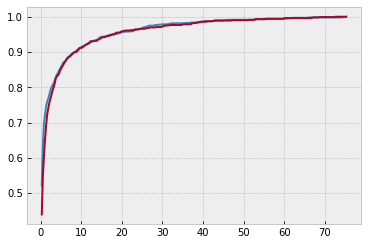

In [8]:
radar_hist, bin_edges = np.histogram(df_marco.RADAR.values,bins="auto",normed=True)
pluvi_hist, bin_edges2 = np.histogram(df_marco.Pluviometro.values,bins=bin_edges,normed=True)
dx = bin_edges[1] - bin_edges[0]
radar_cdf = np.cumsum(radar_hist) * dx
pluvi_cdf = np.cumsum(pluvi_hist) * dx
plt.figure()
plt.plot(bin_edges[1:], radar_cdf)
plt.plot(bin_edges[1:],pluvi_cdf)

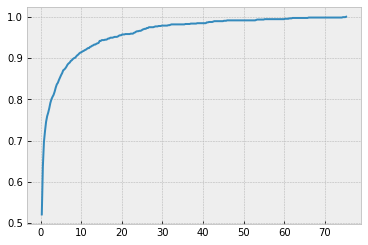

In [9]:
plt.plot(bin_edges[1:], radar_cdf)

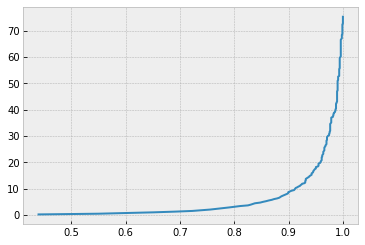

In [10]:
plt.plot(pluvi_cdf,bin_edges[1:])

Para o ajuste dos valores do radar, primeiro encontramos o valor do CDF correspondente ao do radar. E depois com esse valor do CDF encontramos um valor na curva do Pluviometro.

In [11]:
itp_radar_cdf = np.poly1d(np.polyfit(bin_edges[1:], radar_cdf, 5))
itp_pluvi_ppf = np.poly1d(np.polyfit(pluvi_cdf, bin_edges[1:], 3))

0.9641054333550713


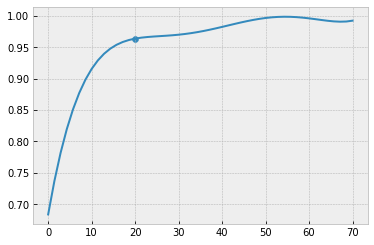

In [12]:
x = np.linspace(0,70)
radar = 20
cdf_radar = itp_radar_cdf(20)
print(cdf_radar)
plt.plot(x,itp_radar_cdf(x))
plt.scatter(radar,cdf_radar)


Ajustar o gráfico ppf do pluviometro com algum polinomio é mais complicado, veja abaixo como a curva vai ter um comportamento estranho.

31.42334539771832


(0, 100)

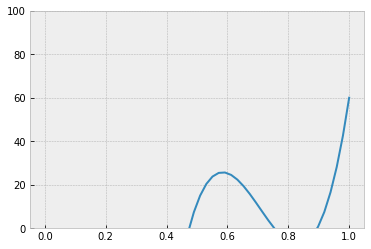

In [13]:
valor_corrigido = itp_pluvi_ppf(cdf_radar)

eixo_cdf = np.linspace(0,1)
print(valor_corrigido)
plt.plot(eixo_cdf,itp_pluvi_ppf(eixo_cdf))
#plt.scatter(valor_corrigido,valor_corrigido)
plt.ylim((0,100))

Para encontrar uma curva satisfatoria para ambos os casos, vou usar uma Spline

* https://en.wikipedia.org/wiki/Spline_(mathematics)
* https://en.wikipedia.org/wiki/Spline_interpolation

Eu acredito que com uma sigmoid tambem seria possivel ajustar o ppf.

https://en.wikipedia.org/wiki/Sigmoid_function

In [14]:
x = np.linspace(0,80,50)

radar_dist = stats.rv_histogram(np.histogram(df_marco.RADAR.values,bins="auto",normed=True))
pluvi_dist = stats.rv_histogram(np.histogram(df_marco.Pluviometro.values,bins="auto",normed=True))

In [15]:
itp_radar_cdf = UnivariateSpline(x, radar_dist.cdf(x),k=3,s=0)

Vamos ajustar o um valor de radar de 20mm

0.9560556564988376


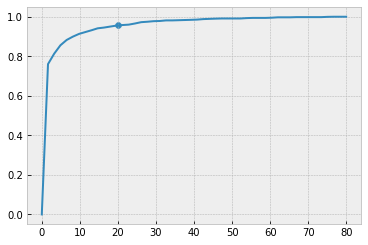

In [16]:
itp_radar = itp_radar_cdf(radar)
print(itp_radar)
plt.plot(x,itp_radar_cdf(x))
plt.scatter(radar,itp_radar)

O problema dessa interpolação é que os valores de x **precisa** estar aumentando

In [17]:
itp_pluvi_ppf = InterpolatedUnivariateSpline(pluvi_dist.cdf(x),x, k=3)

ValueError: x must be strictly increasing

In [18]:
pluvi_cdf = pluvi_dist.cdf(x)
pluvi_cdf

array([0.        , 0.7189414 , 0.80445737, 0.84854614, 0.88042352,
       0.89737301, 0.91036148, 0.92081694, 0.93029679, 0.93684981,
       0.94435484, 0.94926829, 0.95538029, 0.96      , 0.96181004,
       0.96446062, 0.96682927, 0.96878049, 0.9697561 , 0.97408734,
       0.97560976, 0.97560976, 0.97756098, 0.98078723, 0.98441343,
       0.98634146, 0.98678776, 0.98829268, 0.98829268, 0.98926829,
       0.98926829, 0.98926829, 0.9902439 , 0.99219512, 0.99238267,
       0.99317073, 0.99317073, 0.99512195, 0.99512195, 0.99512195,
       0.99512195, 0.9963026 , 0.99797757, 0.99804878, 0.99804878,
       0.99902439, 0.99902439, 0.99902439, 1.        , 1.        ])

Descobrir onde o array não está "crescendo"

In [19]:
idx_increasing = (pluvi_cdf - np.roll(pluvi_cdf,1))[1:] > 0
idx_increasing = np.insert(idx_increasing,0,True)
idx_increasing

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True, False, False,  True, False])

In [20]:
pluvi_cdf = pluvi_cdf[idx_increasing]
x = x[idx_increasing]

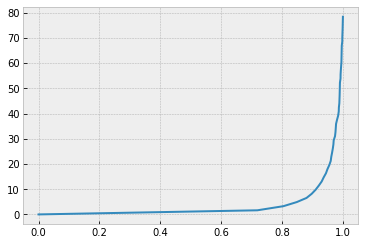

In [21]:
plt.plot(pluvi_cdf,x)

In [22]:
itp_pluvi_ppf = UnivariateSpline(pluvi_cdf,x, k=5,s=1)

Vamos agora jogar o valor da interpolação do radar, na curva ppf do pluviometro.

Valor real de precipitação : 19.62mm, quando o Radar mostrar valor de 20mm


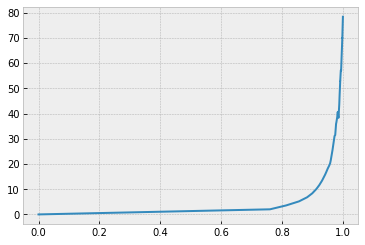

In [23]:
itp_pluvi = itp_pluvi_ppf(itp_radar)
print(f"Valor real de precipitação : {round(itp_pluvi.tolist(),2)}mm, quando o Radar mostrar valor de {radar}mm")
plt.plot(itp_radar_cdf(x),itp_pluvi_ppf(itp_radar_cdf(x)));


In [24]:
meses = ["Janeiro",
"Fevereiro",
"Março",
"Abril",
"Maio",
"Junho",
"Julho",
"Agosto",
"Setembro",
"Outubro",
"Novembro",
"Dezembro"]

In [25]:
def save_graph(radar_cdf, pluvi_cdf,corrected_quantiles, month):
    plt.figure()

    n_month = meses[month-1]

    plt.title(n_month)
    
    plt.plot(corrected_quantiles, radar_cdf,label="Radar")
    plt.plot(corrected_quantiles, pluvi_cdf,label="Pluviometro")

    name = "IMAGENS/CDFs/{}.png".format(n_month)
    
    plt.legend()
    plt.savefig(name)

In [26]:
def isIncresing(array):
    return all((array - np.roll(array,1))[1:] > 0)

def idx_of_Increasing(array):
    idx_increasing = (array - np.roll(array,1))[1:] > 0
    idx_increasing = np.insert(idx_increasing,0,True)
    return idx_increasing


In [27]:
def cdf(radar,pluviometro,k=3):
    

    
    radar_dist = stats.rv_histogram(np.histogram(radar, bins="auto",normed=True))
    pluvi_dist = stats.rv_histogram(np.histogram(pluviometro,bins="auto",normed=True))

    max_ = max(np.max(radar),np.max(pluviometro))
    
    x = np.linspace(0,max_,50)
    radar_cdf = radar_dist.cdf(x)
    itp_radar_cdf = UnivariateSpline(x, radar_cdf,s=1,k=3)

    pluvi_cdf = pluvi_dist.cdf(x)
    if not isIncresing(pluvi_cdf):
        idx_increasing = idx_of_Increasing(pluvi_cdf)
        pluvi_cdf = pluvi_cdf[idx_increasing]
        x = x[idx_increasing]
    itp_pluvi_ppf = UnivariateSpline(pluvi_cdf,x, s=1,k=3)
    
    save_graph(radar_dist.cdf(x),pluvi_dist.cdf(x),x,month)
    
    return lambda x: itp_pluvi_ppf(itp_radar_cdf(x))

In [28]:
def correction(serie,itps):
    month = serie["start"].month
    
    serie["CDF_CORR"] = itps[month](serie["RADAR"])
    return serie

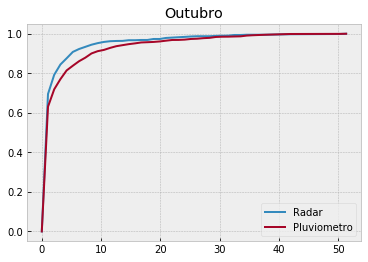

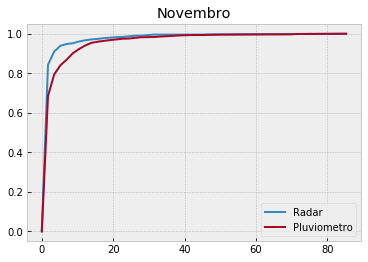

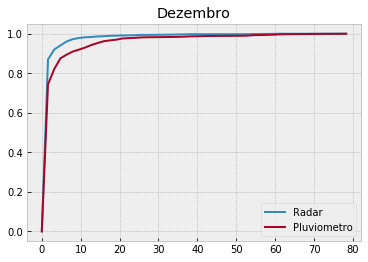

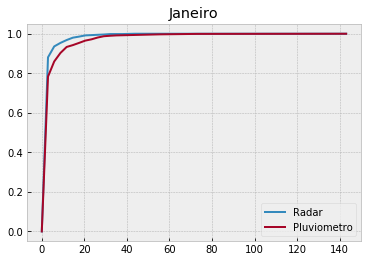

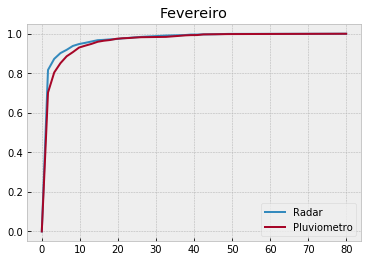

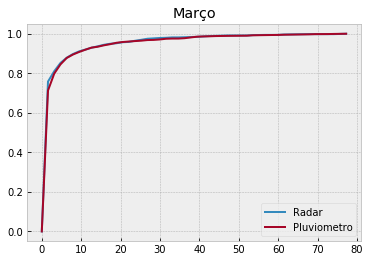

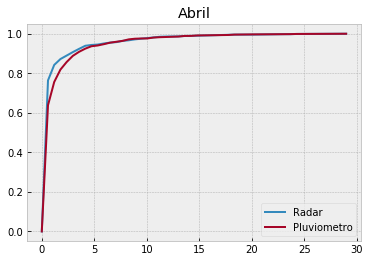

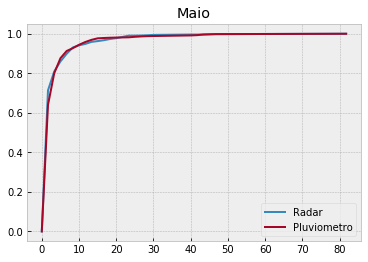

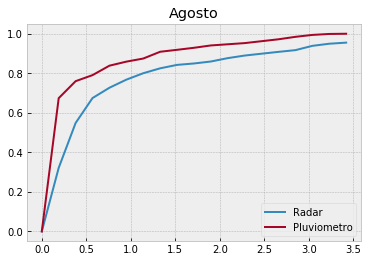

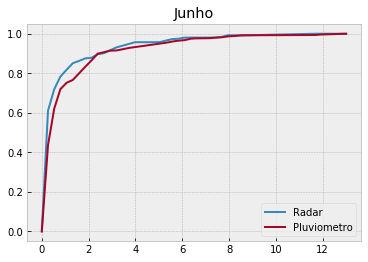

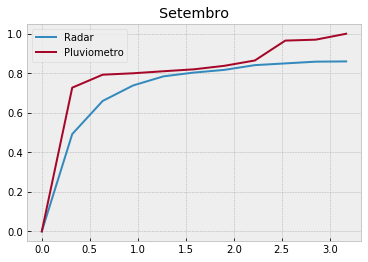

In [29]:
months = df.start.dt.month.unique()
functions = {}
itps = {}
for month in months:
    df_month = df[df.start.dt.month == month]    
    itps[month] = cdf(df_month.RADAR.values,df_month.Pluviometro.values)
    

In [30]:
df = df.apply(correction,args=[itps],axis=1)
df.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CDF_CORR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364,0.9643906593531182
2,2016-10-14 07:20:00,MB_ANHA1,00:10:00,0.25,0.594438,-0.344438,0.9602440682006892
3,2016-10-14 08:10:00,MB_ANHA1,00:50:00,3.25,1.569860,1.680140,1.1097719013563594
4,2016-10-14 09:10:00,MB_ANHA1,01:40:00,5.00,2.367961,2.632039,1.4039279815681456
6,2016-10-14 11:40:00,MB_ANHA1,00:10:00,0.25,0.274750,-0.024750,0.9614528539858156


In [31]:
df["CDF_ERROR"] = df.Pluviometro - df.CDF_CORR
df.head()

,start,station,duration,Pluviometro,RADAR,ERROR,CDF_CORR,CDF_ERROR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.25,0.214636,0.035364,0.9643906593531182,-0.714391
2,2016-10-14 07:20:00,MB_ANHA1,00:10:00,0.25,0.594438,-0.344438,0.9602440682006892,-0.710244
3,2016-10-14 08:10:00,MB_ANHA1,00:50:00,3.25,1.569860,1.680140,1.1097719013563594,2.14023
4,2016-10-14 09:10:00,MB_ANHA1,01:40:00,5.00,2.367961,2.632039,1.4039279815681456,3.59607
6,2016-10-14 11:40:00,MB_ANHA1,00:10:00,0.25,0.274750,-0.024750,0.9614528539858156,-0.711453


In [32]:
df[["CDF_CORR", "CDF_ERROR"]] = df[["CDF_CORR", "CDF_ERROR"]].astype(float)

In [33]:
df.describe()

,duration,Pluviometro,RADAR,ERROR,CDF_CORR,CDF_ERROR
count,8544,8544.000000,8544.000000,8544.000000,8.544000e+03,8.544000e+03
mean,0 days 00:36:18.230337,2.682317,1.705295,0.977022,-2.509249e+07,2.509249e+07
std,0 days 00:47:43.212458,6.951322,5.194622,5.869782,9.025687e+08,9.025687e+08
min,0 days 00:10:00,0.015625,0.010000,-53.711793,-4.067672e+10,-1.700031e+06
25%,0 days 00:10:00,0.187500,0.037430,-0.030878,1.348555e+00,-1.562064e+00
50%,0 days 00:20:00,0.375000,0.162219,0.174438,1.760624e+00,-9.053916e-01
75%,0 days 00:40:00,2.000000,0.853044,0.820891,2.010928e+00,2.742566e-01
max,0 days 17:00:00,143.000000,77.127213,142.990000,1.700085e+06,4.067672e+10


In [34]:
df

,start,station,duration,Pluviometro,RADAR,ERROR,CDF_CORR,CDF_ERROR
1,2016-10-13 08:30:00,MB_ANHA1,00:10:00,0.2500,0.214636,0.035364,0.964391,-0.714391
2,2016-10-14 07:20:00,MB_ANHA1,00:10:00,0.2500,0.594438,-0.344438,0.960244,-0.710244
3,2016-10-14 08:10:00,MB_ANHA1,00:50:00,3.2500,1.569860,1.680140,1.109772,2.140228
4,2016-10-14 09:10:00,MB_ANHA1,01:40:00,5.0000,2.367961,2.632039,1.403928,3.596072
6,2016-10-14 11:40:00,MB_ANHA1,00:10:00,0.2500,0.274750,-0.024750,0.961453,-0.711453
7,2016-10-14 12:00:00,MB_ANHA1,00:10:00,0.2500,0.121554,0.128446,0.970610,-0.720610
8,2016-10-14 12:40:00,MB_ANHA1,00:20:00,1.2500,0.625225,0.624775,0.961421,0.288579
9,2016-10-20 16:00:00,MB_ANHA1,00:50:00,11.0000,0.880495,10.119505,0.980026,10.019974
11,2016-10-20 19:00:00,MB_ANHA1,01:50:00,8.2500,3.004278,5.245722,1.745019,6.504981
12,2016-10-20 21:00:00,MB_ANHA1,00:10:00,0.2500,0.011158,0.238842,0.980595,-0.730595
